# Modelo De Predição de valores de algueis de apartamentos na Cidade de curitiba
# Base de dados reais obtidos através de webscraping no site Viva Real no dia 24_09_2023

In [1]:
# bibliotecas utilizadas
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import folium
import os

#Desativando warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Carregando todos os .csv na pasta bases em um df
path = 'bases/'

dataframes = []

for file in os.listdir(path):
    if file.endswith('.csv'):
        file_path = os.path.join(path, file)
        df = pd.read_csv(file_path,sep=';')
        dataframes.append(df)

df = pd.concat(dataframes, ignore_index=True)

In [2]:
# Carregando apenas cidade de Curitiba
df = pd.read_csv('bases/vivareal_curitiba _20230924.csv',sep=';')

In [3]:
df.head()

,descricao,endereco,area,quartos,suites,wc,vagas,valor,condominio,w_link,tipo,cep,lat,lon
0,Descubra seu novo lar no Ecoville,"Rua Monsenhor Ivo Zanlorenzi, 4400",116,2,1,2,1,3800,500,https://www.vivareal.com.br/imovel/apartamento...,APARTMENT,81210000,-25.442428,-49.347093
1,"Apartamento com 02 quartos, sendo 01 suite, 01...","Rua Tomé de Souza, 67",82,2,1,2,1,1650,332,https://www.vivareal.com.br/imovel/apartamento...,APARTMENT,81010010,-25.474001,-49.267148
2,Cada detalhe pensado para o seu conforto,"Rua Euclides da Cunha, 1530",155,2,1,3,2,4500,987,https://www.vivareal.com.br/imovel/apartamento...,APARTMENT,80730360,-25.432228,-49.299071
3,Imobiliária Cilar Aluga Casa 1 Quarto no Lindo...,"Rua Capitão João Zaleski, 1763",55,1,0,1,0,970,-,https://www.vivareal.com.br/imovel/casa-1-quar...,HOME,81010080,-25.478285,-49.281509
4,Apartamento mobiliado com 2 Suítes e 1 Vaga Ju...,"Rua Augusto Stresser, 48",75,2,2,3,1,4900,726,https://www.vivareal.com.br/imovel/apartamento...,APARTMENT,80030340,-25.417935,-49.261458


In [4]:
# Informacoes basicas sobre a base
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9356 entries, 0 to 9355
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   descricao   9271 non-null   object
 1   endereco    9356 non-null   object
 2   area        9356 non-null   object
 3   quartos     9356 non-null   object
 4   suites      9356 non-null   object
 5   wc          9356 non-null   object
 6   vagas       9356 non-null   object
 7   valor       9356 non-null   int64 
 8   condominio  9356 non-null   object
 9   w_link      9356 non-null   object
 10  tipo        9356 non-null   object
 11  cep         9356 non-null   int64 
 12  lat         9356 non-null   object
 13  lon         9356 non-null   object
dtypes: int64(2), object(12)
memory usage: 1023.4+ KB


In [5]:
df['tipo'].value_counts( normalize=True) * 100

tipo
APARTMENT                     29.606670
OFFICE                        23.054724
BUSINESS                      16.994442
HOME                          14.450620
COMMERCIAL_PROPERTY            3.634032
CONDOMINIUM                    3.174434
SHED_DEPOSIT_WAREHOUSE         2.597264
RESIDENTIAL_ALLOTMENT_LAND     1.485678
COMMERCIAL_BUILDING            1.090209
PENTHOUSE                      1.058145
COMMERCIAL_ALLOTMENT_LAND      1.047456
KITNET                         0.812313
ALLOTMENT_LAND                 0.395468
BUILDING                       0.352715
FLAT                           0.106883
PARKING_SPACE                  0.042753
TWO_STORY_HOUSE                0.032065
RESIDENTIAL_BUILDING           0.032065
LOFT                           0.010688
FARM                           0.010688
HOTEL                          0.010688
Name: proportion, dtype: float64

In [6]:
# Criando um dataframe apenas de apartamentos

df_apartament = df[df['tipo'] == 'APARTMENT']
df_apartament.drop_duplicates(inplace=True)
len(df_apartament)

2770

In [7]:
# Verificando valores nulos
df_apartament.isnull().sum()

descricao     26
endereco       0
area           0
quartos        0
suites         0
wc             0
vagas          0
valor          0
condominio     0
w_link         0
tipo           0
cep            0
lat            0
lon            0
dtype: int64

In [8]:
# Verificando tipos de dados
df_apartament.dtypes

descricao     object
endereco      object
area          object
quartos       object
suites        object
wc            object
vagas         object
valor          int64
condominio    object
w_link        object
tipo          object
cep            int64
lat           object
lon           object
dtype: object

In [9]:
df_apartament['quartos'].value_counts( normalize=True) * 100

quartos
1    33.862816
2    31.155235
3    29.386282
4     4.801444
5     0.505415
6     0.216606
8     0.036101
7     0.036101
Name: proportion, dtype: float64

In [10]:
df_map = df_apartament.copy()

# excluir linhas onde tem valores '-' na lat ou lon
df_map = df_map[(df_map['lat'] != '-') | (df_map['lon'] != '-')]
df_map.head()

,descricao,endereco,area,quartos,suites,wc,vagas,valor,condominio,w_link,tipo,cep,lat,lon
0,Descubra seu novo lar no Ecoville,"Rua Monsenhor Ivo Zanlorenzi, 4400",116,2,1,2,1,3800,500,https://www.vivareal.com.br/imovel/apartamento...,APARTMENT,81210000,-25.442428,-49.347093
1,"Apartamento com 02 quartos, sendo 01 suite, 01...","Rua Tomé de Souza, 67",82,2,1,2,1,1650,332,https://www.vivareal.com.br/imovel/apartamento...,APARTMENT,81010010,-25.474001,-49.267148
2,Cada detalhe pensado para o seu conforto,"Rua Euclides da Cunha, 1530",155,2,1,3,2,4500,987,https://www.vivareal.com.br/imovel/apartamento...,APARTMENT,80730360,-25.432228,-49.299071
4,Apartamento mobiliado com 2 Suítes e 1 Vaga Ju...,"Rua Augusto Stresser, 48",75,2,2,3,1,4900,726,https://www.vivareal.com.br/imovel/apartamento...,APARTMENT,80030340,-25.417935,-49.261458
9,"Apartamento com 2 dormitórios para alugar, 37 ...","Rua Wanda Wolf, 1600",38,2,0,1,0,1100,375,https://www.vivareal.com.br/imovel/apartamento...,APARTMENT,82410380,-25.372489,-49.329957


In [ ]:
# Função para substituir '-' por 0 e converter para int ou float
def replace_dash_with_zero(value):
    if value == '-':
        return 0
    else:
        try:
            return int(value)
        except ValueError:
            try:
                return float(value)
            except ValueError:
                return value

# Aplicar a função em todas as células do DataFrame
df_apartament = df_apartament.applymap(replace_dash_with_zero)


In [ ]:
# Utilizando a lat e lon , criar um gráfico com a localidade de cada anuncio
# Criando um mapa
mapa = folium.Map(
    widht = 600 , height=400,
    location=[-25.4295963, -49.2712724],
    zoom_start=4
)
# Passando os valores de lat e lon para o mapa
for lat, lon in zip(df_apartament['lat'], df_apartament['lon']):
    folium.Marker(
        location=[lat, lon], icon=folium.Icon(color='green')
    ).add_to(mapa)

mapa

In [ ]:
from folium import plugins

# Criando mapa de calor
lat = df_map['lat'].values
lon = df_map['lon'].values

coordenadas = []

for lat, lon in zip(lat, lon):
    coordenadas.append([lat, lon])

mapa_calor = folium.Map(
    width=1024, height=800,
    location=[-25.4295963, -49.2712724],
    zoom_start=4,
    tiles='Stamen Terrain'
)

mapa_calor.add_child(plugins.HeatMap(coordenadas))
mapa_calor

In [15]:
df_apartament.dtypes

descricao      object
endereco       object
area            int64
quartos         int64
suites          int64
wc              int64
vagas           int64
valor           int64
condominio      int64
w_link         object
tipo           object
cep             int64
lat           float64
lon           float64
dtype: object

In [16]:
colunas_numericas = df_apartament.select_dtypes(include=['int64']).columns
colunas_numericas = colunas_numericas.drop('cep')

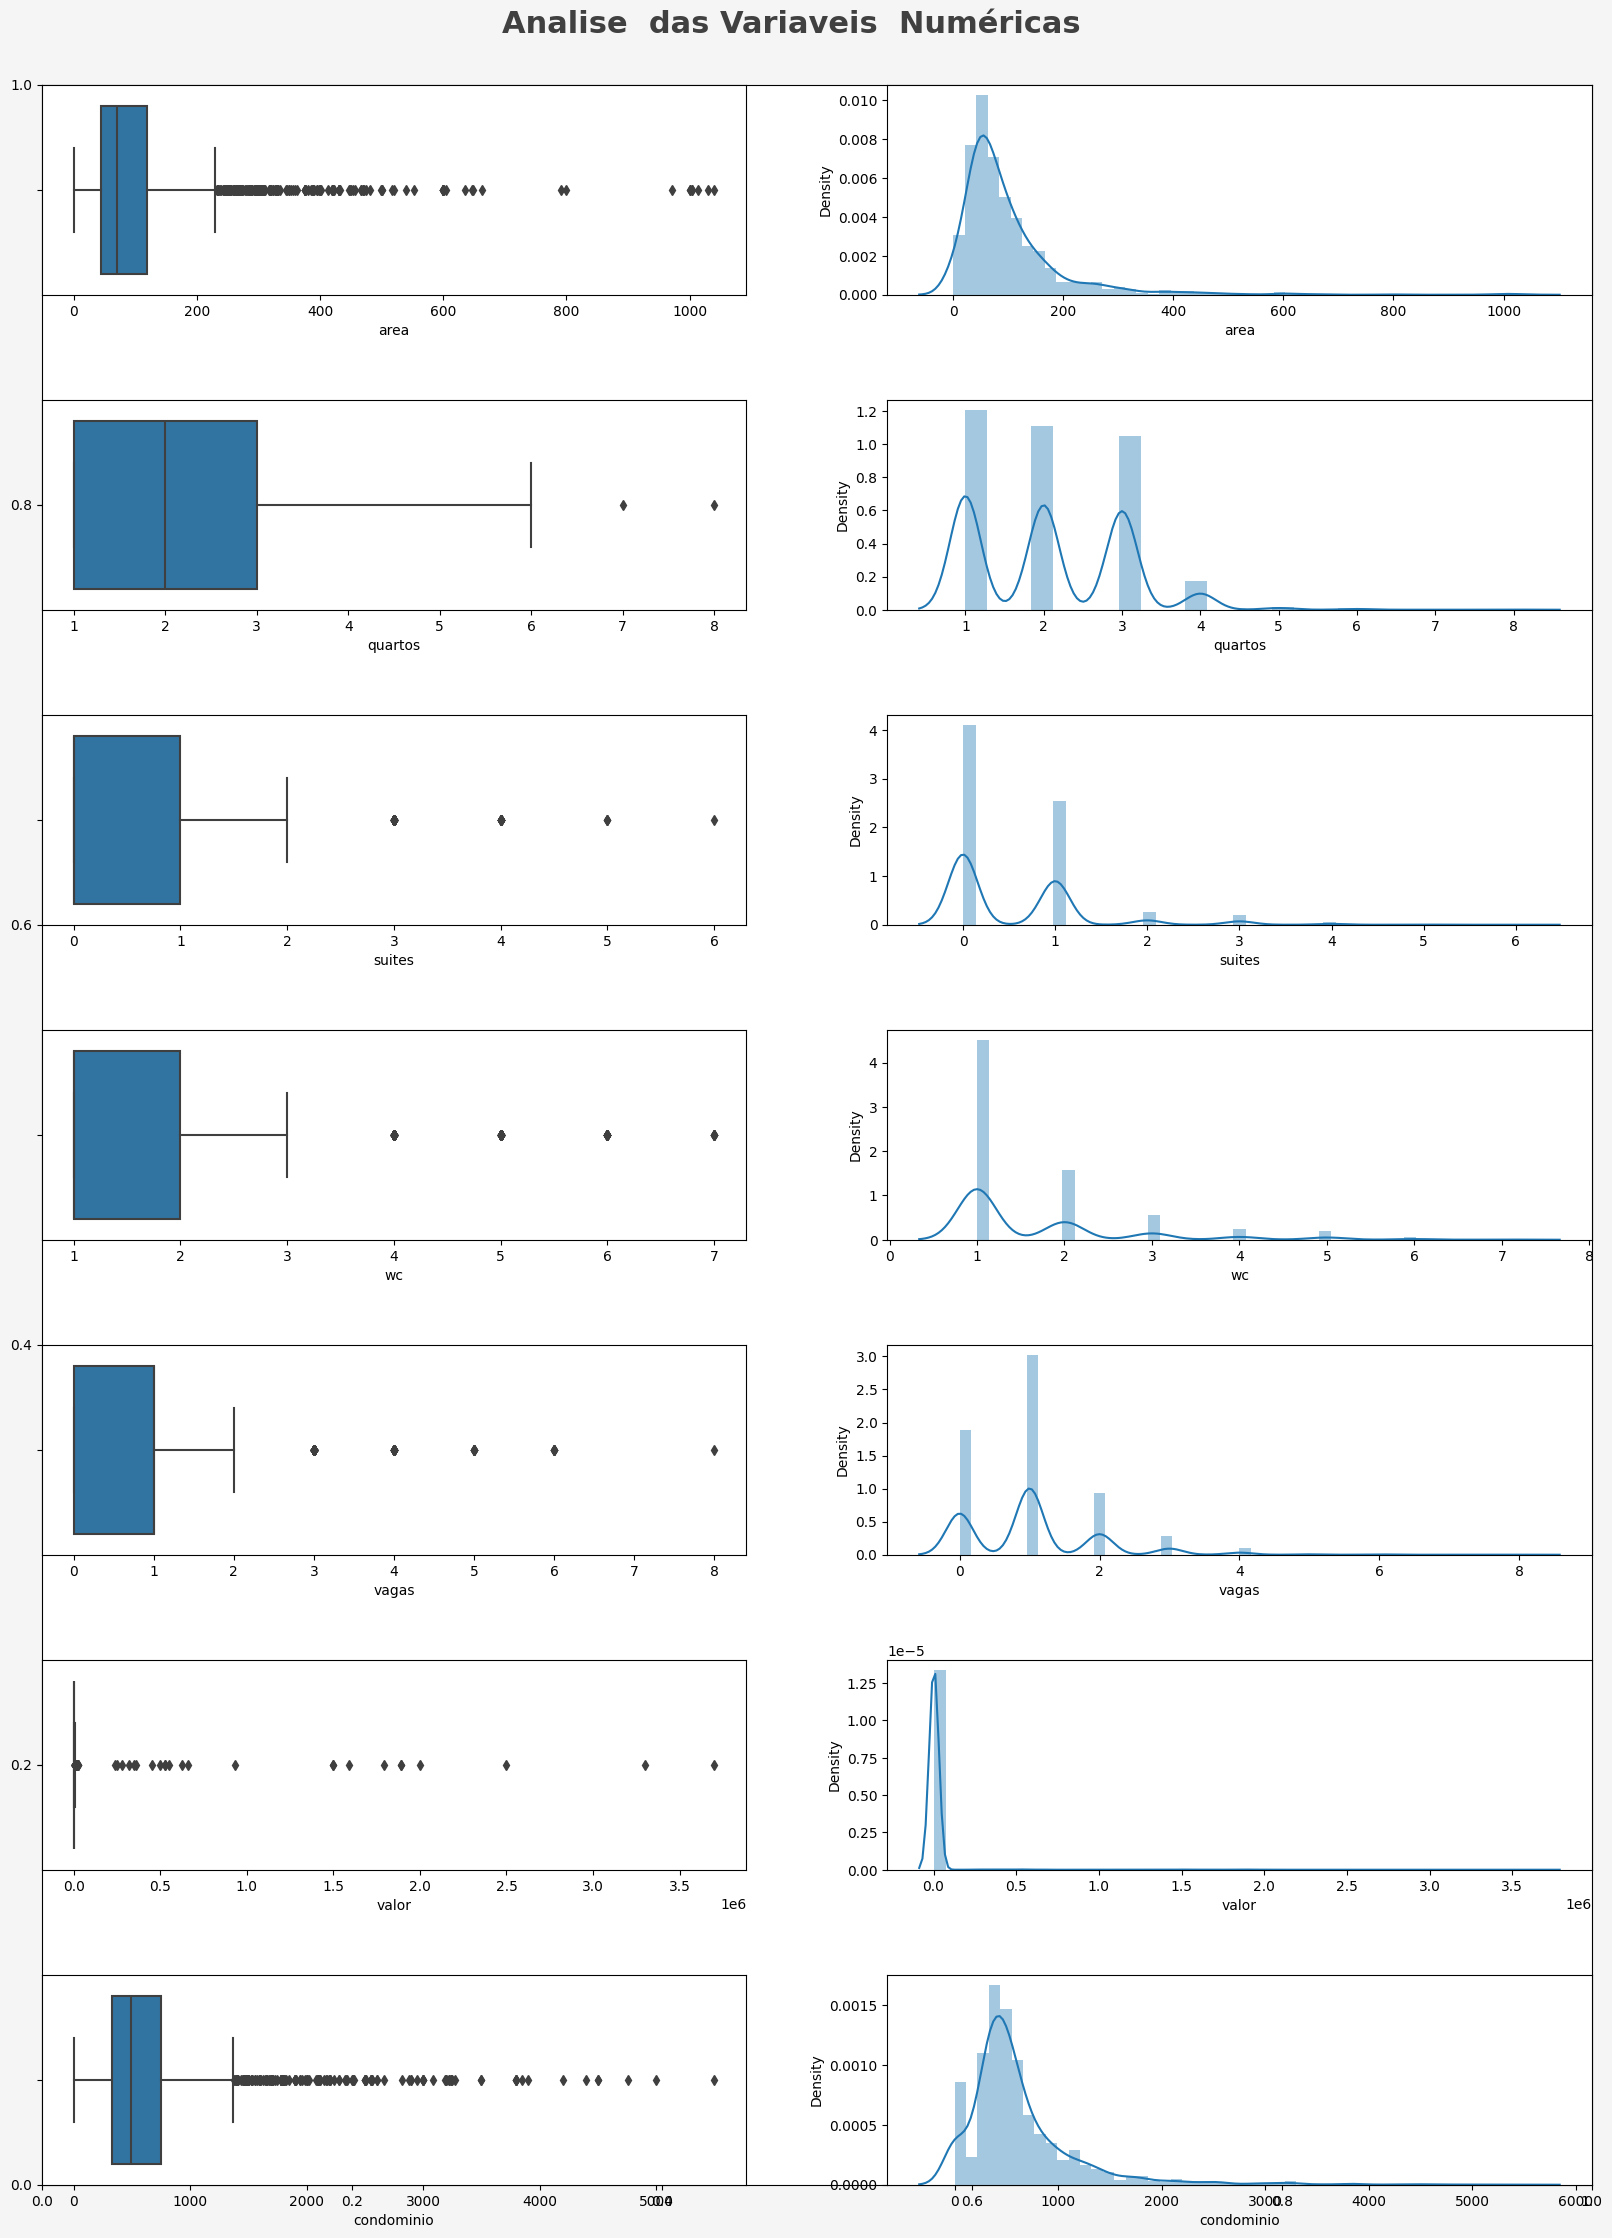

In [34]:
# Tamanho

figura,eixo = plt.subplots( figsize = (20,25))

# Cor de fundo
cor_fundo = '#F5F5F5'
figura.set_facecolor(cor_fundo)

#Paleta de cores
paleta_cores =  sns.color_palette('flare', len(colunas_numericas) *2)

# Titulo
plt.suptitle ('Analise  das Variaveis  Numéricas' , fontsize = 22 , color = '#404040', fontweight = 600) 

# Estrutura
linhas = 7
colunas = 2
posicao = 1

for coluna in colunas_numericas:

    plt.subplot( linhas, colunas, posicao )
    
    # Plot
    sns.boxplot( data = df_apartament , x = coluna )
    
    posicao += 1
    
    plt.subplot( linhas , colunas , posicao )

    # Plot 
    
    sns.distplot( df_apartament[coluna] )

    posicao += 1

# Ajuste de grid

plt.subplots_adjust( top = 0.95 , hspace = 0.5)

In [27]:
# Analisando as variaveis para identificar outliers

df_apartament['condominio'].describe()

count    2770.000000
mean      623.219312
std       556.499993
min         0.000000
25%       332.750000
50%       490.000000
75%       749.750000
max      5500.000000
Name: condominio, dtype: float64

In [20]:
# Resetando o index
df_apartament.reset_index(drop=True, inplace=True)

In [33]:
# Encontrando os maiores valores
df_apartament['suites'].nlargest(10)

437     6.0
648     5.0
1434    5.0
2760    5.0
260     4.0
318     4.0
573     4.0
866     4.0
1117    4.0
1124    4.0
Name: suites, dtype: float64

In [31]:
df_apartament.iloc[2640]

descricao             Amplo, Ensolarado, melhor local Ecoville!
endereco                                                      0
area                                                        318
quartos                                                       4
suites                                                       24
wc                                                            4
vagas                                                         3
valor                                                      7500
condominio                                               1530.0
w_link        https://www.vivareal.com.br/imovel/apartamento...
tipo                                                  APARTMENT
cep                                                    81200100
lat                                                         0.0
lon                                                         0.0
Name: 2640, dtype: object

In [32]:
# Trocando os dois maiores valores pela média
df_apartament.loc[2640, 'suites'] = df_apartament['suites'].mean()

In [35]:
df_apartament.head()

,descricao,endereco,area,quartos,suites,wc,vagas,valor,condominio,w_link,tipo,cep,lat,lon
0,Descubra seu novo lar no Ecoville,"Rua Monsenhor Ivo Zanlorenzi, 4400",116,2,1.0,2,1,3800,500.0,https://www.vivareal.com.br/imovel/apartamento...,APARTMENT,81210000,-25.442428,-49.347093
1,"Apartamento com 02 quartos, sendo 01 suite, 01...","Rua Tomé de Souza, 67",82,2,1.0,2,1,1650,332.0,https://www.vivareal.com.br/imovel/apartamento...,APARTMENT,81010010,-25.474001,-49.267148
2,Cada detalhe pensado para o seu conforto,"Rua Euclides da Cunha, 1530",155,2,1.0,3,2,4500,987.0,https://www.vivareal.com.br/imovel/apartamento...,APARTMENT,80730360,-25.432228,-49.299071
3,Apartamento mobiliado com 2 Suítes e 1 Vaga Ju...,"Rua Augusto Stresser, 48",75,2,2.0,3,1,4900,726.0,https://www.vivareal.com.br/imovel/apartamento...,APARTMENT,80030340,-25.417935,-49.261458
4,"Apartamento para Aluguel - Centro, 1 Quarto, 4...",0,42,1,1.0,1,1,2200,350.0,https://www.vivareal.com.br/imovel/apartamento...,APARTMENT,80020270,0.000000,0.000000


In [38]:
# Separa a base
caracteristicas = df_apartament[['area' , 'quartos' , 'suites' , 'wc' , 'vagas' , 'condominio']]
previsor = df_apartament['valor']
caracteristicas.shape , previsor.shape

((2770, 6), (2770,))

In [39]:
caracteristicas.head()

,area,quartos,suites,wc,vagas,condominio
0,116,2,1.0,2,1,500.0
1,82,2,1.0,2,1,332.0
2,155,2,1.0,3,2,987.0
3,75,2,2.0,3,1,726.0
4,42,1,1.0,1,1,350.0


In [40]:
previsor.head()

0    3800
1    1650
2    4500
3    4900
4    2200
Name: valor, dtype: int64

In [44]:
# Analisando a correlação
# Proxima de 1 = forte correlação , ambos aumentam ou diminuem
# Proxima de -1 = forte correlação inversa , um aumenta o outro diminui
df_corr = df_apartament.drop(columns=['cep', 'lat', 'lon' ,'w_link' ,'descricao', 'endereco' , 'tipo'])
df_corr.corr()

,area,quartos,suites,wc,vagas,valor,condominio
area,1.000000,0.632750,0.658207,0.699427,0.639727,0.156574,0.632323
quartos,0.632750,1.000000,0.568260,0.653006,0.637956,0.089647,0.476016
suites,0.658207,0.568260,1.000000,0.789610,0.622456,0.126059,0.615283
wc,0.699427,0.653006,0.789610,1.000000,0.681983,0.169013,0.646697
vagas,0.639727,0.637956,0.622456,0.681983,1.000000,0.159754,0.579305
valor,0.156574,0.089647,0.126059,0.169013,0.159754,1.000000,0.123153
condominio,0.632323,0.476016,0.615283,0.646697,0.579305,0.123153,1.000000


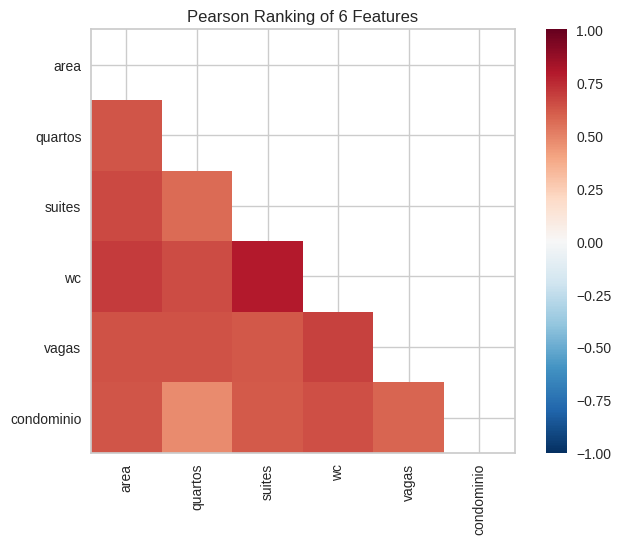

In [46]:
# Utilizando o yellowbrik
from yellowbrick.features import Rank2D

correlacao = Rank2D(algorithm='pearson')

correlacao.fit(caracteristicas, previsor)
correlacao.transform(caracteristicas)
correlacao.show();


In [47]:
# Separando a base entre treino e teste
from sklearn.model_selection import train_test_split

x_treino, x_teste, y_treino, y_teste = train_test_split(
    caracteristicas,previsor, test_size=0.2, random_state=42
)

In [50]:
# Observando o tamanho das bases
print(f'Dados de treino: {x_treino.shape[0]}')
print(f'Dados de teste: {x_teste.shape[0]}')

Dados de treino: 2216
Dados de teste: 554


In [64]:
# features mais relevante
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest

def selecao_features (x_treino , y_treino):

    selecao = SelectKBest( score_func=mutual_info_regression, k = 'all')

    selecao.fit(x_treino, y_treino)

    return selecao

scores = selecao_features( x_treino, y_treino)

# Analisar o resultado

for posicao , score in enumerate(scores.scores_):
    print(f'{x_treino.columns[posicao]} : {score}')

area : 0.44759803464648495
quartos : 0.22811089270032348
suites : 0.3324400564262944
wc : 0.30590333878386833
vagas : 0.3697225096545269
condominio : 0.45164266106197726


In [72]:
# Construção do modelo
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

modelo_random_forest = RandomForestRegressor(max_depth=5)

modelo_random_forest.fit(x_treino, y_treino)

RandomForestRegressor(max_depth=5)

In [74]:
# Avaliar performance do modelo
previsoes = modelo_random_forest.predict(x_teste)

In [77]:
# Funcoes de metricas
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

print(f'RMSE: {sqrt(mean_squared_error(y_teste, previsoes))}'),
print(f'Score: {r2_score(y_teste, previsoes)}')

RMSE: 120716.50932507744
Score: 0.22989382070834097


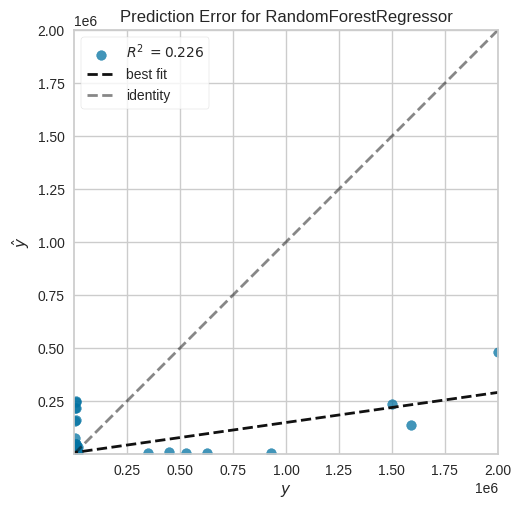

In [78]:
from yellowbrick.regressor import PredictionError

modelo = RandomForestRegressor(max_depth=5)
erro_modelo = PredictionError(modelo)

erro_modelo.fit(x_treino, y_treino)
erro_modelo.score(x_teste, y_teste)
erro_modelo.show();

In [79]:
# Exportar modelo
import joblib
joblib.dump(modelo_random_forest, 'modelo_random_forest.pkl')

['modelo_random_forest.pkl']

In [81]:
# Carregar modelo

funcao_modelo = joblib.load('modelo_random_forest.pkl')
funcao_modelo

RandomForestRegressor(max_depth=5)

In [82]:
funcao_modelo.predict(x_teste.head(1).values)

array([2006.779914])

In [85]:
y_teste.head(1) , x_teste.head(1)

(1106    1890
 Name: valor, dtype: int64,
       area  quartos  suites  wc  vagas  condominio
 1106    44        1     0.0   1      0       428.0)